### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from flowjax.flows import NeuralSplineFlow
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as onp
from jax import random
from numpyro.infer import MCMC, NUTS
import seaborn as sns
from rnpe.plot_utils import pairplot


ModuleNotFoundError: No module named 'rnpe'

### Simulate

In [2]:
key = random.PRNGKey(0)
key, theta_key, sim_key = random.split(key, 3)
x_dim = 100
n_sim = 10000

# As described in https://arxiv.org/pdf/1708.01974.pdf
theta = random.normal(theta_key, (n_sim, 1))*5  # std 5, var 25
x_demean = random.normal(sim_key, (n_sim, x_dim))  # N(0, 1)  # var 1
x_misspecified_demean = x_demean*jnp.sqrt(2) # var 2 rather than 1
x, x_misspecified = (x_demean + theta), (x_misspecified_demean + theta)  # N(theta, var)

# Compute summary statistics
s = jnp.column_stack((x.mean(axis=1), x.var(axis=1)))
s_misspecified = jnp.column_stack((x_misspecified.mean(axis=1), x_misspecified.std(axis=1)))

# Scale variables (based on simulations only)
s_mean, s_std = s.mean(axis=0), s.std(axis=0)
s = (s-s_mean)/s_std
s_misspecified = (s_misspecified-s_mean)/s_std

theta_mean, theta_std = theta.mean(axis=0), theta.std(axis=0)
theta = (theta-theta_mean)/theta_std

obs_num = 0
s_obs = s_misspecified[obs_num]
s_obs_well_specified = s[obs_num]
theta_true = theta[obs_num]

s = jnp.delete(s, obs_num, axis=0)
theta = jnp.delete(theta, obs_num, axis=0)
s_misspecified = jnp.delete(s_misspecified, obs_num, axis=0)

### Train marginal likelihood flow

In [3]:
key, flow_key, train_key = random.split(key, 3)
flow = NeuralSplineFlow(flow_key, target_dim=s.shape[1], B=22)
flow, losses = train_flow(train_key, flow, s, max_epochs=30)

 50%|█████     | 15/30 [00:40<00:40,  2.70s/it, train=2.84, val=2.84]

Max patience reached.


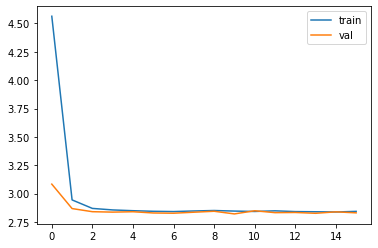

In [4]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Denoise with MCMC

In [5]:
from numpyro.infer import NUTS
from rnpe.denoise import student_t_denoiser

kernel = NUTS(student_t_denoiser, target_accept_prob=0.99) # Smaller step because of peaky distribution
mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000)
key, mcmc_key = random.split(key)
mcmc.run(mcmc_key, s_obs, flow)
mcmc.print_summary()


sample: 100%|██████████| 15000/15000 [00:38<00:00, 392.34it/s, 127 steps of size 1.14e-02. acc. prob=0.99] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.46      0.22      0.48      0.28      0.65   2391.87      1.00
      x[1]      0.47      1.16      0.39     -1.36      2.31   1087.80      1.00

Number of divergences: 0


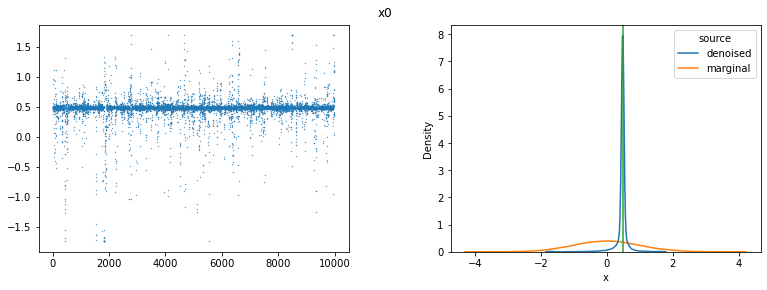

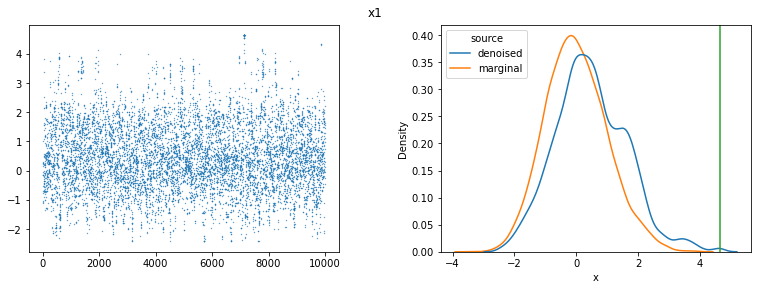

In [6]:
import pandas as pd

for sample_name, sample in mcmc.get_samples().items():
    sample = onp.array(sample)
    if sample.ndim == 1:
        sample = onp.expand_dims(sample, axis=1)  # to avoid iterating over items
    for i, col in enumerate(onp.transpose(sample)):
        col = onp.clip(col, jnp.quantile(col, 0.001), jnp.quantile(col, 0.999))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12, 4)
        fig.suptitle(sample_name + str(i))
        ax1.scatter(range(len(col)), col, s=0.1)

        if sample_name == "x":
            # Plot p(s) too
            df = pd.DataFrame({
                "x": onp.concatenate((col, s[:, i])),
                "source": onp.repeat(["denoised", "marginal"], [len(col), len(s[:, i])])
            })

            sns.kdeplot(data=df, x="x", hue="source", ax=ax2, common_norm=False)
            ax2.axvline(s_obs[i].item(), color="tab:green")

        else:
            sns.kdeplot(col)
        plt.show()



TypeError: savefig() missing 1 required positional argument: 'fname'

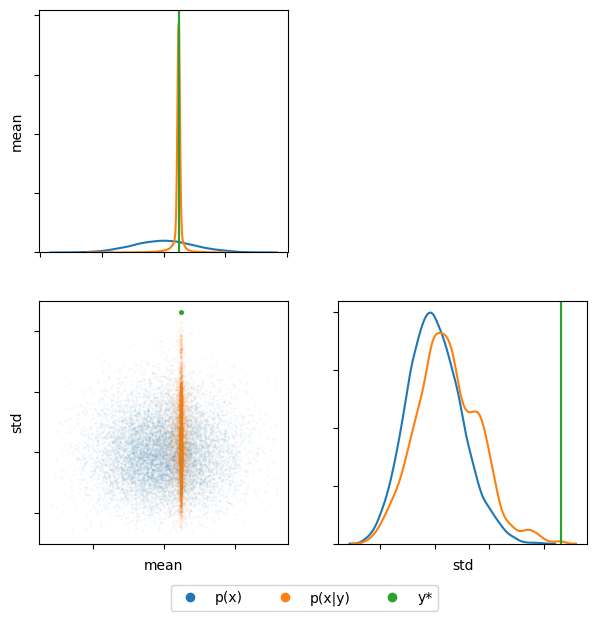

In [7]:
s_names = ["mean", "std"]
denoised = mcmc.get_samples()["x"]
pairplot((s, denoised), s_obs, col_names=s_names, names=["p(x)", "p(x|y)", "y*"])
plt.savefig()

### Posterior inference

In [8]:
key, flow_key, train_key = random.split(key, 3)

posterior_flow = NeuralSplineFlow(
    flow_key,
    target_dim=theta.shape[1],
    condition_dim=s.shape[1])

posterior_flow, losses = train_flow(train_key, posterior_flow, theta, s, max_epochs=30)

100%|██████████| 30/30 [00:32<00:00,  1.09s/it, train=-2.43, val=-2.44]


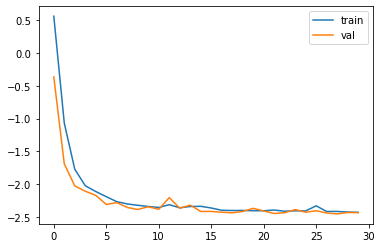

In [9]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Sample non-robust and robust posterior

In [24]:
denoised = mcmc.get_samples()["x"]
n_samples = denoised.shape[0]

keys, key1, key2 = random.split(key, 3)

posteriors = {
    "prior": theta[:n_samples],
    "robust": posterior_flow.sample(key1, denoised),
    "non_robust": posterior_flow.sample(key2, s_obs, n=n_samples),
}

posteriors = {k: onp.array(v) for k,v in posteriors.items()}


(0.0, 0.8)

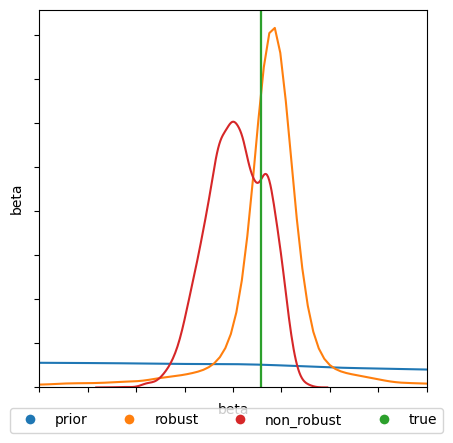

In [28]:
names = list(posteriors.keys())
pairplot(list(posteriors.values()), theta_true, col_names = ["beta", "gamma"], names=names + ["true"], trim_quantile=0.05)
plt.xlim(0, 0.8)

In [ ]:
# Get true dgp posterior
sum_y = s_obs[0]*s_std[0]*x_dim
likelihood_std = 2  # for p(theta|y)
prior_std = 5
mu = (sum_y/likelihood_std**2) * (1/prior_std**2 + x_dim/likelihood_std**2)**(-1)
std = jnp.sqrt((1/prior_std**2 + x_dim/likelihood_std**2)**(-1))
mu = (mu - theta_mean) / theta_std
std = std / theta_std

In [ ]:
from jax.scipy.stats import norm

x = jnp.linspace(0, 1, 500)
y = jnp.exp(norm.logpdf(x, loc = mu, scale=std))

In [ ]:
pairplot(list(posteriors.values()), theta_true, col_names = ["beta", "gamma"], names=names, trim_quantile=0.05)
plt.plot(x, y, color="green")
plt.xlim(0.2, 0.7)